## 自动编码器
正如您在介绍中读到的，自动编码器是一种无监督机器学习算法，它将图像作为输入，并尝试使用瓶颈（也称为潜在空间）中较少的位数重建图像。图像主要在瓶颈处被压缩。自动编码器中的压缩是通过对网络进行一段时间的训练来实现的，并且在学习过程中，它会尝试在瓶颈处最好地表示输入图像。JPEG 和 JPEG 无损压缩技术等通用图像压缩算法无需任何类型的训练即可压缩图像，并且在压缩图像方面表现相当不错。

自动编码器类似于主成分分析 (PCA) 等降维技术。它​​们使用线性变换将数据从高维投影到低维，并尝试保留数据的重要特征，同时删除非必要部分。

然而，自动编码器和 PCA 之间的主要区别在于转换部分：正如您已经读到的，PCA 使用线性变换，而自动编码器使用非线性变换。

现在您对自动编码器有了一定的了解，让我们来分解这个术语并尝试对它有一些直觉！
https://www.datacamp.com/tutorial/autoencoder-keras-tutorial

![img](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1522830223/Autoencoder_structure_af1jh8.png)

自动编码器可以分为三个部分

编码器：网络的这一部分将输入压缩或下采样为更少的位数。这些更少的位数所代表的空间通常称为潜在空间或瓶颈。瓶颈也称为“最大压缩点”，因为此时输入被最大程度地压缩。这些代表原始输入的压缩位统称为输入的“编码”。
解码器：网络的这一部分尝试仅使用输入的编码来重建输入。当解码器能够完全按照输入到编码器的方式重建输入时，可以说编码器能够为输入生成最佳编码，解码器能够很好地重建输入！
自动编码器有很多种，例如卷积自动编码器、去噪自动编码器、变分自动编码器和稀疏自动编码器。但是，正如您在介绍中读到的那样，您将只关注本教程中的卷积和去噪自动编码器。使用 Keras 在 Python 中实现卷积自动编码器

由于输入数据由图像组成，因此使用卷积自动编码器是个好主意。它不是自动编码器的变体，而是堆叠了卷积层的传统自动编码器：基本上是用卷积层替换全连接层。卷积层与最大池化层一起将输入从宽（28 x 28 图像）和薄（单通道或灰度）转换为小（潜在空间中的 7 x 7 图像）和厚（128 通道）。

这有助于网络从图像中提取视觉特征，从而获得更准确的潜在空间表示。重建过程使用上采样和卷积，称为解码器。下采样是将图像压缩为低维度的过程，也称为编码器。

值得注意的是，编码器主要压缩输入图像，例如：如果您的输入图像尺寸为 176 x 176 x 1 (~30976)，则最大压缩点的尺寸可以是 22 x 22 x 512 (~247808)。因此，在这种情况下，您从尺寸为 176 x 176 的灰度图像开始，并通过几个卷积层和三个最大池化层，您的图像最终被下采样为尺寸为 22 x 22，但通道数从 1 增加到 512。如上所述，您的输入从宽（176 x 176）和薄（1）变为小（22x22）和厚（512）。

### 加载数据
notMNIST 数据集是字母 A 到 J 的字体字形的图像识别数据集。它与经典的MNIST数据集非常相似，后者包含手写数字 0 到 9 的图像：在这种情况下，您会发现 NotMNIST 数据集包含 28x28 灰度图像，共 70,000 个字母，从 A 到 J，分为 10 个类别，每个类别 6,000 张图像。

提示：如果您想了解如何使用 MNIST 数据集实现多层感知器 (MLP) 进行分类任务，请查看本教程。

NotMNIST 数据集未在 Keras 或 TensorFlow 框架中预定义，因此您必须从此来源下载数据。数据将以ubyte.gzip格式下载，但目前无需担心！您很快就会学习如何读取字节流格式并将其转换为 NumPy 数组。那么，让我们开始吧！

该网络将在 Nvidia Tesla K40 上进行训练，因此如果您在 GPU 上训练并使用 Jupyter Notebook，则需要添加三行代码，其中使用名为的模块指定 CUDA 设备顺序和 CUDA 可见设备os。

在下面的代码中，您基本上使用 在笔记本中设置环境变量os.environ。在初始化 Keras 之前，最好执行以下操作以限制 Keras 后端 TensorFlow 使用第一个 GPU。如果您训练的机器上的 GPU 是0，请确保使用0而不是1。您可以通过在终端上运行一个简单的命令来检查：例如，nvidia-smi

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [4]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import RMSprop
from keras.models import Model
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline


在这里，您定义一个函数来打开gzip文件，使用 读取文件bytestream.read()。您将图像尺寸和图像总数传递给此函数。然后，使用np.frombuffer()将存储在变量中的字符串转换buf为 类型的 NumPy 数组float32。

接下来，将数组重塑为三维数组或张量，其中第一维是图像数量，第二维和第三维是图像的维度。最后，返回 NumPy 数组data。

In [5]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28, 28)
        return data


In [7]:
train_data = extract_data('../data/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('../data/t10k-images-idx3-ubyte.gz', 10000)


In [8]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels


In [9]:
train_labels = extract_labels('../data/train-labels-idx1-ubyte.gz', 60000)
test_labels = extract_labels('../data/t10k-labels-idx1-ubyte.gz',10000)

In [10]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))


Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [11]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: D)')

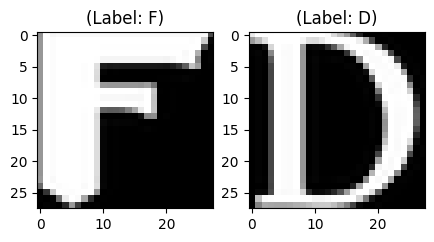

In [12]:
plt.figure(figsize=[5, 5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28, 28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28, 28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")


In [13]:
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)
train_data.shape, test_data.shape


((60000, 28, 28, 1), (10000, 28, 28, 1))

In [14]:
train_data.dtype, test_data.dtype


(dtype('float32'), dtype('float32'))

In [15]:
np.max(train_data), np.max(test_data)


(255.0, 255.0)

In [16]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)


In [17]:
np.max(train_data), np.max(test_data)


(1.0, 1.0)

In [18]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_ground, valid_ground = train_test_split(train_data,
                                                                train_data,
                                                                test_size=0.2,
                                                                random_state=13)


In [19]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape=(x, y, inChannel))


如前所述，自动编码器分为两个部分：编码器和解码器。

编码器

第一层有 32 个 3 x 3 大小的过滤器，后面跟着一个下采样（最大池化）层，
第二层将有 64 个大小为 3 x 3 的过滤器，后面跟着另一个下采样层，
编码器的最后一层将有 128 个大小为 3 x 3 的过滤器。


解码器

第一层将有 128 个大小为 3 x 3 的过滤器，后面跟着一个上采样层，/li>
第二层将有 64 个大小为 3 x 3 的过滤器，后面紧接着另一个上采样层，
编码器的最后一层将有 1 个大小为 3 x 3 的过滤器。
每次使用时，最大池化层都会将输入下采样两倍，而每次使用时，上采样层都会将输入上采样两倍。

In [20]:
def autoencoder(input_img):
    # encoder
    # input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu',
                   padding='same')(input_img)  # 28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # 14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu',
                   padding='same')(pool1)  # 14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  # 7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(
        pool2)  # 7 x 7 x 128 (small and thick)

    # decoder
    conv4 = Conv2D(128, (3, 3), activation='relu',
                   padding='same')(conv3)  # 7 x 7 x 128
    up1 = UpSampling2D((2, 2))(conv4)  # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu',
                   padding='same')(up1)  # 14 x 14 x 64
    up2 = UpSampling2D((2, 2))(conv5)  # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid',
                     padding='same')(up2)  # 28 x 28 x 1
    return decoded


In [21]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer=RMSprop())


In [22]:
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,625 (1.20 MB)

 Trainable params: 314,625 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,
                                    epochs=epochs, verbose=1, validation_data=(valid_X, valid_ground))


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - loss: 0.0765 - val_loss: 0.0164
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 0.0166 - val_loss: 0.0142
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - loss: 0.0095 - val_loss: 0.0083
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - loss: 0.0082 - val_loss: 0.0075
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 12/50
375/375 ━━━━━━━━━━

KeyboardInterrupt: 

In [24]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


NameError: name 'autoencoder_train' is not defined